# How to use Lime with visualizations

In [34]:
!pip install lime
!pip install transformers
!pip install datasets

## Linear Regression

### Imports

In [35]:
import lime
from sklearn.linear_model import LinearRegression

from sklearn.datasets import load_breast_cancer
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np

### Load data

In [36]:
# Read the DataFrame, first using the feature data
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

In [37]:
# Read the DataFrame, first using the feature data
data = load_breast_cancer() 
df = pd.DataFrame(data.data, columns=data.feature_names)

In [38]:
# Add a target column, and fill it with the target data
df['target'] = data.target

In [39]:
# Set up the data for modelling 
y=df['target'].to_frame() # define Y
X=df[df.columns.difference(['target'])] # define X
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # create train and test

In [40]:
df.describe()
pd.set_option("max_rows", None)

benign = df[df['target'] == 1] # benign
malign = df[df['target'] == 0] # malign

benign.head()



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
19,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,0.1885,0.05766,0.2699,0.7886,2.058,23.560,0.008462,0.014600,0.02387,0.013150,0.01980,0.002300,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259,1
20,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,0.1967,0.06811,0.1852,0.7477,1.383,14.670,0.004097,0.018980,0.01698,0.006490,0.01678,0.002425,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183,1
21,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,0.1815,0.06905,0.2773,0.9768,1.909,15.700,0.009606,0.014320,0.01985,0.014210,0.02027,0.002968,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773,1
37,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,0.1467,0.05863,0.1839,2.3420,1.170,14.160,0.004352,0.004899,0.01343,0.011640,0.02671,0.001777,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,1
46,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,0.1769,0.06503,0.1563,0.9567,1.094,8.205,0.008968,0.016460,0.01588,0.005917,0.02574,0.002582,8.964,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409,1


In [41]:
malign.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Build model

In [42]:
lr = LinearRegression().fit(X_train, y_train)

# make prediction and check model accuracy 
lr_y_pred = lr.predict(X_test)

# Performance
print("rooted mean squared error:")
print(np.sqrt(mean_squared_error(y_test, lr_y_pred)))



rooted mean squared error:
0.25319727974507644


### Lime visualizations

In [43]:
# Importing the module for LimeTabularExplainer
from lime import lime_tabular

X_train = np.array(X_train)
# Instantiating the explainer object by passing in the training set, and the extracted features
explainer_lime = lime_tabular.LimeTabularExplainer(X_train,
                                                        feature_names=data.feature_names,
                                                        verbose=True,
                                                        mode='regression')

In [44]:
X_test = np.array(X_test)
explain_data_point = explainer_lime.explain_instance(X_test[40], lr.predict, num_features=10)

Intercept 0.49952852883160626
Prediction_local [0.93300585]
Right: 1.1525971931887788


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


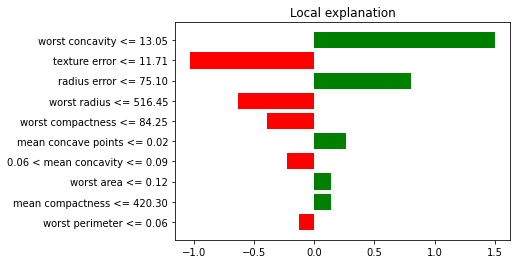

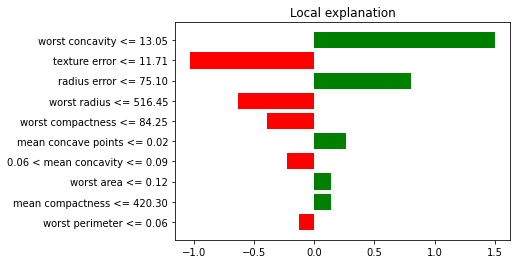

In [45]:
explain_data_point.as_pyplot_figure()

## XGB

### Imports

In [46]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

### Build XGB model

In [47]:
# build model - Xgboost
xgb_mod=xgb.XGBClassifier(random_state=42,gpu_id=0) # build classifier
xgb_mod=xgb_mod.fit(X_train, y_train.values.ravel()) 

# make prediction and check model accuracy 
xgb_y_pred = xgb_mod.predict(X_test)

# Performance
accuracy = accuracy_score(y_test, xgb_y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 95.61%


### Lime visualizations

In [48]:
explain_data_point = explainer_lime.explain_instance(X_test[40], xgb_mod.predict, num_features=10)

Intercept 0.5216985477690514
Prediction_local [1.36723469]
Right: 1


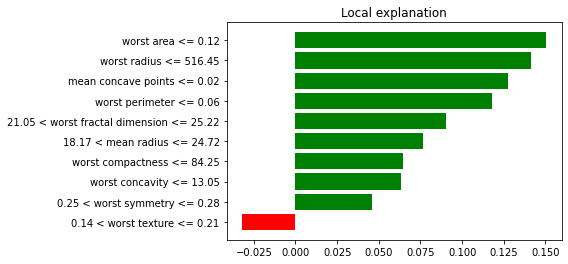

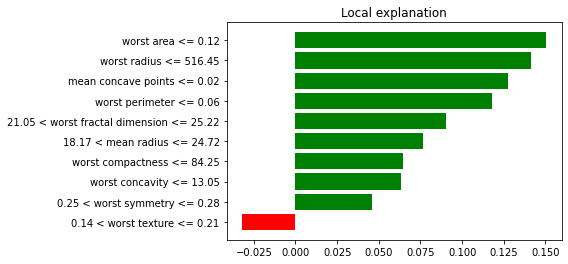

In [49]:
explain_data_point.as_pyplot_figure()

## CNN

### Imports

In [50]:
import matplotlib.pyplot as plt
import os
import PIL
import random
import scipy
import transformers
import datasets
import pathlib

#CNN imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

from skimage.segmentation import mark_boundaries
from skimage.transform import resize

#XAI
from lime import lime_image
import lime.lime_tabular
from lime import lime_text
from lime.lime_text import LimeTextExplainer


### Load data

In [51]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [52]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3670


In [53]:
batch_size = 32
img_shape = 128

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_shape, img_shape),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


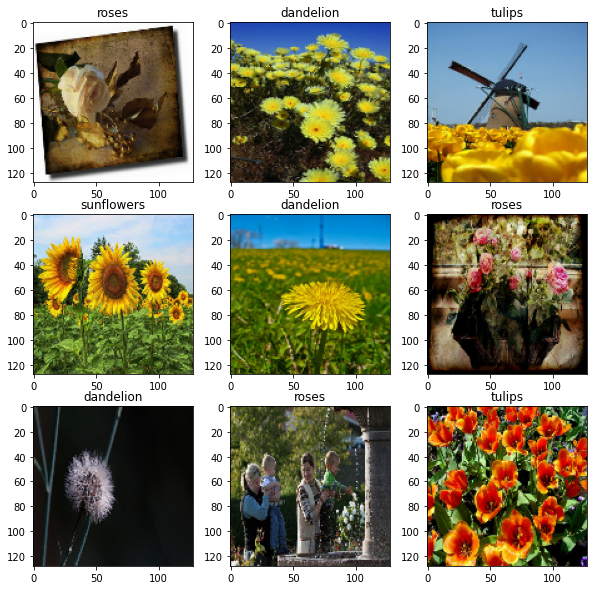

In [55]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [56]:
#turning the dataset into numpy arrays
import tensorflow_datasets as tfds
X_Y = tfds.as_numpy(train_ds)
X = []
y = []
for ex in X_Y:
    X += list(ex[0])
    y += list(ex[1])
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Build model

In [57]:
num_classes = len(class_names)


model = Sequential([
    
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_shape, img_shape, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3,activation='relu', name='conv5_3'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])




In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
epochs=4
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test,y_test)
)


Epoch 1/4
62/62 [==============================] - 25s 393ms/step - loss: 1.4881 - accuracy: 0.3264 - val_loss: 1.2609 - val_accuracy: 0.4592
Epoch 2/4
62/62 [==============================] - 24s 390ms/step - loss: 1.0898 - accuracy: 0.5623 - val_loss: 1.0198 - val_accuracy: 0.5944
Epoch 3/4
62/62 [==============================] - 24s 389ms/step - loss: 0.9451 - accuracy: 0.6294 - val_loss: 1.1012 - val_accuracy: 0.5501
Epoch 4/4
62/62 [==============================] - 24s 389ms/step - loss: 0.8560 - accuracy: 0.6670 - val_loss: 1.0142 - val_accuracy: 0.5697


### Plot Validation

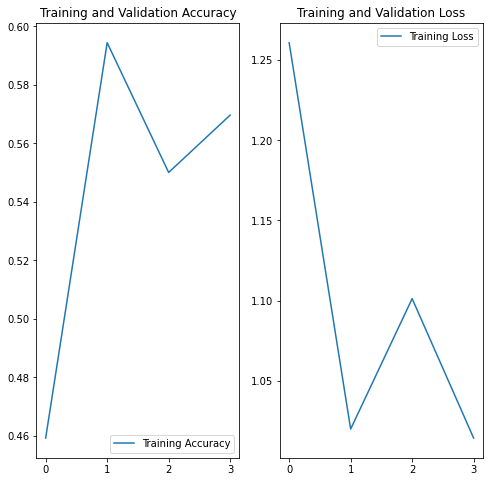

In [60]:
acc = history.history['val_accuracy']

loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Lime visualisations CNN

In [61]:
X_train = X_train.astype('double')
X_test = X_test.astype('double')
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[4], 
         model.predict
)

  0%|          | 0/1000 [00:00<?, ?it/s]

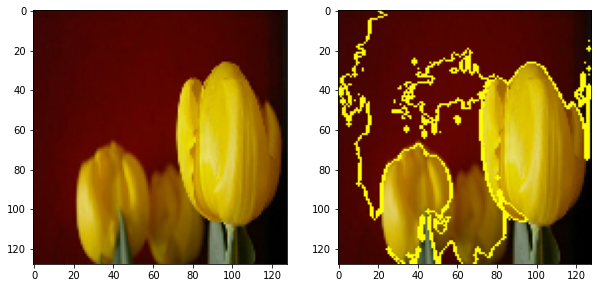

In [62]:

image, mask = explanation.get_image_and_mask(
         model.predict(
              X_test[4].reshape((1,128,128,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
# display images
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(image.astype("uint8"))
ax[1].imshow(mark_boundaries(image.astype("uint8"), mask))


## NLP

In [63]:
import lime
import sklearn
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups

from lime import lime_text
from lime.lime_text import LimeTextExplainer

### Get data

In [64]:

categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

In [65]:

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

### Build model and pipeline

In [66]:

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')



0.9177288528389339

In [67]:
c = make_pipeline(vectorizer, rf)


### Create explainer

In [68]:
explainer = LimeTextExplainer(class_names=['atheism', 'christian'])

In [69]:

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)

print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])



Probability(christian) = 0.432
True class: daisy


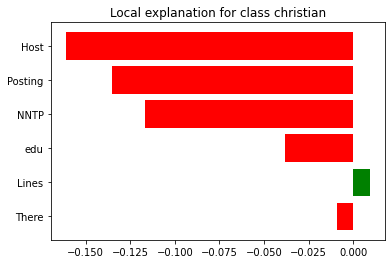

In [70]:
fg = exp.as_pyplot_figure()

In [71]:
exp.show_in_notebook(text=True)